In [1]:
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from shapely.prepared import prep
from shapely.geometry import Point
import itertools
from cmocean import cm

In [2]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.3,-122.2)
    ax.set_ylim(37.5,38.1)
    return(fig, ax)

In [3]:
ds = xr.open_dataset("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd")
ds = ds.sel(lat=slice(37.5,38.1),lon=slice(-123.3,-122.2))
ds = ds.isel(time=slice(-10,-1)).load()

In [99]:
ds

<xarray.Dataset>
Dimensions:                (lat: 33, lon: 52, nv: 2, time: 9, time_1: 1)
Coordinates:
  * lat                    (lat) float32 37.51392 37.5319 ... 38.0713 38.08928
  * lon                    (lon) float32 -123.28059 -123.259766 ... -122.21867
  * time                   (time) datetime64[ns] 2021-05-14T08:00:00 ... 2021...
    time_run               (time) datetime64[ns] 2021-05-14T08:00:00 ... 2021...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 1620959400 1620963000
    depth_bnds             (nv) float32 0.0 1.0
    wgs84                  int8 -127
    processing_parameters  int8 -127
    radial_metadata        int8 -127
    depth                  float32 0.55
    time_offset            (time) datetime64[ns] 2012-01-01 ... 2012-01-01
    u                      (time, lat, lon) float32 -0.099999994 ... nan
    v                      (time, lat, lon) float32 0.06 0.06 nan ... nan nan
    dopx                   (time, lat, lon) float32 0.71 0.62 nan ... nan nan
    dopy                   (time, lat, lon) float32 0.61 0.74 nan ... nan nan
    hdop                   (time, lat, lon) float32 0.94 0.96 nan ... nan nan
    number_of_sites        (time, lat, lon) float32 2.0 3.0 nan ... nan nan nan
    number_of_radials      (time, lat, lon) float32 5.0 5.0 nan ... nan nan nan
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202105140300siohfruwlsrtvuswc2km
    date_created:              2021-05-14T04:50:38Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2021-05-14T03:52:18Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_2km_Resolutio...

__Calculate Speed__

$ U = \sqrt{u^2 + v^2} $

In [100]:
ds['speed'] = np.sqrt(ds.u**2 + ds.v**2)

__Plot Data grids for a single hour__

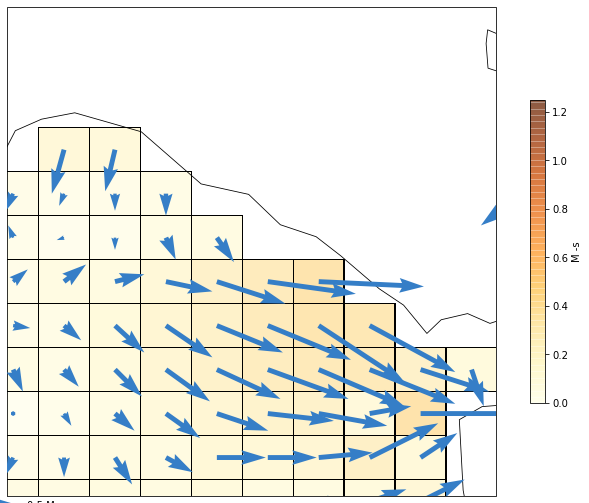

In [101]:
fig = plt.figure(figsize=(12,9))
cart_proj = ccrs.PlateCarree()
ax = plt.axes(projection=cart_proj)
ax.coastlines('10m', linewidth=0.8)
cmaps = ['YlOrBr','Reds', 'Greens', 'Purples',]
for i, ds in enumerate([ds]):
    # Set the GeoAxes to the projection used by WRF

    # Add coastlines
    # # Add arrows to show the wind vectors !!!!
    x = ds.lon
    y = ds.lat
    x,y = np.meshgrid(x,y)

    u = ds.isel(time=0).u
    v = ds.isel(time=0).v
    spd = ds.isel(time=0).speed
    masked = np.ma.masked_array(spd.values, spd.values == np.nan)
    color = ['k','g','r']
    ax.pcolormesh(x, y, masked,vmin=1,vmax=1, zorder=2, facecolor='none', edgecolors='.75', lw=(i+1)/2,
           cmap='gray',transform=ccrs.PlateCarree())
    
    cax = plt.pcolormesh(x,y,masked,transform=ccrs.PlateCarree(),cmap=get_cmap(cmaps[0]),vmin=0,vmax=1.25,alpha=.5)
    
    ax.grid(True, color="k", lw=2,zorder=10,alpha=.75)
    Q = plt.quiver( x, y, u, v,color='#357ec7',width=.002, transform=ccrs.PlateCarree(), zorder=100, scale=10, units="xy")



qk = plt.quiverkey(Q, 
                   0.025, -.02,                  # x,y label position
                   .25,
                   '0.5 M -s', # choose units + update string
                   labelpos='E',                # add label to the right
                   coordinates='axes'
                   )

ax.set_xlim(-122.7,-122.5)
ax.set_ylim(37.75,37.95)
cbar = plt.colorbar(cax, shrink=.62)
cbar.set_label('M -s')

# plt.savefig('Figures/all_station.png',dpi=300,bbox_inches='tight', pad_inches=0.25)

# Gap filling logic
1. Create a Land Mask

1. Filling gaps using high or lower resolution data
    - __spatially interpolate__
2. gap is on edge of time (within 3 hours or start times)
    - __spatially interpolate__
3. gap is on the space 
    - __temporal interpolation__
4. gap is less than three hours
    - __temporal interpolation__
5. gap is greater than three hours
    - __spatially interpolate__
    
Spatial filling methods:
- __bilinear interpolation__
- __krigg__

Temporal filling methods:
- __linear interpolation__

__Creating a 1km grid with a land mask__

In [ ]:
#2km 
x = ds_2k.lon
y = ds_2k.lat
x,y = np.meshgrid(x,y)


land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())
land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]
points = [Point(point) for point in zip(x.ravel(), y.ravel())]
land = []
# land.extend([tuple(point.coords)[0] for point in filter((land_polygons_prep[0].covers), points)])
land.extend([tuple(point.coords)[0] for point in itertools.filterfalse((land_polygons_prep[0].covers), points)])

In [ ]:
u = ds_2k.isel(time=55).u

fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = u.plot(cmap=cm.balance,add_colorbar=False)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)

# plt.savefig('Figures/2-HFR-pre_interp_u.png',dpi=300,bbox_inches='tight', pad_inches=0.1)
# plt.show()

In [ ]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
f['u'].plot(color='#E37E24')

p = ds_2k.sel(lat=37.8,lon=-123.1,method='nearest')
p['u'].plot(zorder=10,label='actual')

i = interp.sel(lat=37.8,lon=-123.1,method='nearest')
i.plot(label='interp',ls='dashed',color="#a5514e")


map_point = i.isel(time=55)
x = map_point['time'].values
y= map_point.values
plt.scatter(x,y,zorder=100,marker='x',color='r')

plt.legend()

# plt.savefig('Figures/2-HFR-interp_time_series_together.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [ ]:
map_point

In [ ]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
f['u'].plot(color='#E37E24')

map_point = f['u'].isel(time=55)
x = map_point['time'].values
y= map_point.values
plt.scatter(x,y,zorder=100,marker='x',color='r')

plt.savefig('Figures/2-HFR-no-interp_time_series.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [ ]:
x = map_point['time']
y = map_point[''].values
y

In [ ]:
interp_u = ds_2k.isel()['u'].interpolate_na(dim='time',method='linear')
interp_v = ds_2k.isel()['u'].interpolate_na(dim='time',method="linear")

u = interp_u.isel(time=55)

fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = u.plot(cmap=cm.balance,add_colorbar=False,vmin=-1,vmax=1)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)


plt.show()

In [ ]:
ds_2k['u_interp'] = interp_u
ds_2k['v_interp'] = interp_v
ds_2k['speed_interp'] = np.sqrt(interp_u**2 + interp_v**2)

In [ ]:
fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).isel(time=55).plot(add_colorbar=False)
contours = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).isel(time=55).plot.contour(levels=[0,.1,.2,.3,.4,.5,1],zorder=10,add_labels=True,colors='k')
plt.clabel(contours, inline=1, fontsize=10)

# cax = u.plot(cmap=cm.balance,add_colorbar=False)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)


plt.show()


__Calculate Average difference in speed__

In [ ]:
ds_2k['dir_interp'] = np.rad2deg(np.arctan2(ds_2k['u_interp'], ds_2k['v_interp']))
ds_2k['dir'] = np.rad2deg(np.arctan2(ds_2k['u'], ds_2k['v']))

# avg_diff_dir = np.abs((ds_2k['dir'] - ds_2k['dir_interp'])).mean(dim={'time'})
# avg_diff_speed = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).mean(dim={'time'})

In [ ]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
# f['dir_interp'].plot(color='#E37E24')
f['dir'].plot(color='#E37E24')

# p = ds_2k.sel(lat=37.8,lon=-123.1,method='nearest')
# p['dir_interp'].plot(zorder=10,label='actual')
# p['dir'].plot(zorder=10,label='actual')
# i = interp.sel(lat=37.8,lon=-123.1,method='nearest')
# i.plot(label='interp',ls='dashed',color="#a5514e")


# map_point = i.isel(time=55)
# x = map_point['time'].values
# y= map_point.values
# plt.scatter(x,y,zorder=100,marker='x',color='r')

# plt.legend()

# # plt.savefig('Figures/2-HFR-interp_time_series_together.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [4]:
import geopandas as gpd
from shapely.geometry import Point, box, Polygon
# from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

In [7]:
coast = gpd.read_file("./Data/nos80k/NOS80k.shp").to_crs('EPSG:4326')
coast = coast[~coast.is_valid]
coast['geometry'] = coast.buffer(0)

In [6]:
coast

,ID,geometry
0,0,"MULTIPOLYGON (((-95.15274 49.36692, -95.15265 ..."


/home/pdaniel/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


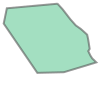

In [8]:
# coast = gpd.read_file("./Data/nos80k/NOS80k.shp").to_crs('EPSG:4326')
# coastline_maks = 
regions_of_interest = {
    "crs":[{'init': 'epsg:4326'}],
    "shapes" : {
        "area_mask" : [
            (-122.9631042, 38.3007146),
            (-122.9658508, 38.3028700),
            (-122.9658508, 38.3028700),
            (-122.9631042, 38.3039476),
            (-123.7417603, 38.2338654),
            (-123.7898254, 37.9994093),
            (-123.2748413, 37.2445416),
            (-122.8683472, 37.2543800),
            (-122.3712158, 37.4050738),
            (-122.4343872, 37.4661386),
            (-122.4618530, 37.5097258),
            (-122.4948120, 37.5772358),
            (-122.4728394, 37.6120557),
            (-122.4961853, 37.7598585),
            (-122.5112915, 37.8293108),
            (-122.6074219, 37.9160343),
            (-122.6074219, 37.9160343),
            (-122.6856995, 37.9712673),
            (-122.7694702, 38.0653924),
            (-122.8889465, 38.2198409),
            (-122.9631042, 38.3007146)
        ],
    },
}

def load_polygons(regions):
    """ Create and return a geopandas dataframe with each of the polygons if interest
    polygons are generated at https://www.keene.edu/campus/maps/tool/

    Returns:
        geopandas.GeoDataFrame: dataframe with each of the polygons of AOI that are geographically references to WGS84
        
    """

    shapes = [k for k in regions['shapes'].keys()]
    polys = [Polygon(regions['shapes'][k]) for k in shapes]
    d = {
        'box': shapes,
        'geometry': polys
        }
    return gpd.GeoDataFrame(d, crs=regions['crs'][0])
regions = load_polygons(regions_of_interest)
coastline = gpd.clip(coast, regions.iloc[0].geometry)

<AxesSubplot:>

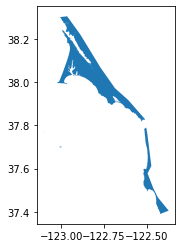

In [24]:
coastline.plot()

In [37]:
lat = ds['lat'].values
lon = ds['lon'].values
xx,yy = np.meshgrid(lon,lat)

coords = []

for i,coor in enumerate(zip(xx.flatten(),yy.flatten())):
    coords.append((i,coor))

def make_point(vals):
    point = Point(vals[1])
    return {"id": vals[0], "geometry": point}

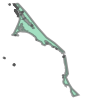

In [51]:
coastline.iloc[0]['geometry']

In [48]:
points[0]

{'id': 0, 'geometry': <shapely.geometry.point.Point at 0x7f4c516bd280>}

In [61]:
import geopandas as gpd
from shapely.geometry import Point, box
# from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#single geom for Norway
# norway = world[world["name"]=="Norway"].dissolve(by='name').iloc[0].geometry

#single geom for the coastline
# coastline = gpd.clip(gpd.read_file("Europe_coastline.shp").to_crs('EPSG:4326'),
#                      norway.buffer(0.25)).iloc[0].geometry

# def make_point(id):
#     point = None
#     while point is None or not norway.contains(point):
#         point = Point(uniform(norway.bounds[0],norway.bounds[2]),
#                       uniform(norway.bounds[1],norway.bounds[3]))
#     return {"id": id, "geometry": point}

def compute_distance(point):
    point['dist_to_coastline'] = point['geometry'].distance(coastline.iloc[0]['geometry'])
    return point

with ThreadPoolExecutor(max_workers=4) as tpe:
    points = list(tqdm(tpe.map(make_point, coords), desc="generating points", total=len(coords)))
    result = list(tqdm(tpe.map(compute_distance, points), desc="computing distances", total=len(points)))

gdf = gpd.GeoDataFrame.from_records(result)

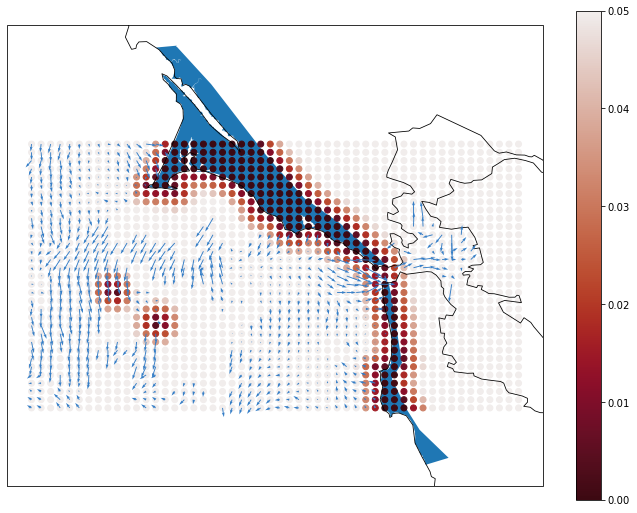

In [119]:
fig = plt.figure(figsize=(12,9))
cart_proj = ccrs.PlateCarree()
ax = plt.axes(projection=cart_proj)
ax.coastlines('10m', linewidth=0.8)

gpd.GeoDataFrame.from_records([{"geometry":coastline.iloc[0]['geometry']}]).plot(ax=ax)
# ax.scatter(gdf['geometry'])
cax = gdf.plot(ax=ax, column='dist_to_coastline', cmap=cm.amp_r,legend=True,vmin=0,vmax=.05)


x = ds.lon
y = ds.lat
x,y = np.meshgrid(x,y)

u = ds.isel(time=0).u
v = ds.isel(time=0).v
Q = plt.quiver( x, y, u, v,color='#357ec7',width=.002, transform=ccrs.PlateCarree(), zorder=100, scale=10, units="xy")

# qk = plt.quiverkey(Q, 
#                    0.025, -.02,                  # x,y label position
#                    .25,
#                    '0.5 M -s', # choose units + update string
#                    labelpos='E',                # add label to the right
#                    coordinates='axes'
#                    )


# ax.set_xlim(-122.735,-122.5)
# ax.set_ylim(37.8,38)